<a href="https://colab.research.google.com/github/varsha2509/Springboard-DS/blob/master/Capstone2/Colab/DeepSat6_Vgg16_TL_Base_UpSampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Install Packages and Mount Google Drive
import pandas as pd
import numpy as np
import cv2
import h5py
import csv
from scipy.io import loadmat
import matplotlib.pyplot as plt 
from google.colab import drive
import os
from os import listdir

from numpy import asarray

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import tensorflow as tf
from tensorflow.keras import layers, models
from keras.preprocessing import image
from tensorflow import keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard
from keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten, ZeroPadding2D
from keras.models import Sequential, Model
from keras.applications import vgg16
from keras import backend as K
from keras import models    
from keras.models import load_model
from keras.models import model_from_json
from sklearn.metrics import balanced_accuracy_score

from matplotlib.colors import ListedColormap


from multiprocessing.pool import ThreadPool



from keras.callbacks import EarlyStopping, ModelCheckpoint

# load vgg model
from keras.applications.vgg16 import VGG16


from skimage.io import imread

from glob import glob

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Springboard/Capstone Projects/Capstone-2/DeepSat-6-Dataset/"

#Mount the drive to colab notebook
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
#Change the current working directory
%cd /content/gdrive/My\ Drive/Springboard/Capstone\ Projects/Capstone-2/DeepSat-6-Dataset/


/content/gdrive/My Drive/Springboard/Capstone Projects/Capstone-2/DeepSat-6-Dataset


# Loading and Cleaning Dataset


In [ ]:
## Load the .mat file to data
data=loadmat('/content/gdrive/My Drive/Springboard/Capstone Projects/Capstone-2/DeepSat-6-Dataset/sat-6-full.mat')

In [ ]:
## Create individual nparrays for train and test from mat
Xtrain = data['train_x'].reshape(-1, 28, 28, 4) #This moves the position of the last column to the first, and clips the RGB values between (0,255)
ytrain = data['train_y'].T #Transposes the y_train array to be of size (324,000,6)
Xtest = data['test_x'].reshape(-1, 28,28,4) #Same as Xtrain
ytest = data['test_y'].T #Same as ytrain

In [ ]:
Xtrain = np.moveaxis(data['train_x'], -1, 0)
Xtest = np.moveaxis(data['test_x'], -1, 0)


In [ ]:
#Load the annotations as individual array
annotations = data['annotations']
annotations

array([[array(['100000'], dtype='<U6'), array(['building'], dtype='<U8')],
       [array(['010000'], dtype='<U6'),
        array(['barren land'], dtype='<U11')],
       [array(['001000'], dtype='<U6'), array(['trees'], dtype='<U5')],
       [array(['000100'], dtype='<U6'),
        array(['grassland'], dtype='<U9')],
       [array(['000010'], dtype='<U6'), array(['road'], dtype='<U4')],
       [array(['000001'], dtype='<U6'), array(['water'], dtype='<U5')]],
      dtype=object)

In [ ]:
#Create a dictionary with values as land categories
land_categories = dict()
for an in range(len(annotations)):
  land_categories[an] = annotations[an][1][0]
land_categories


{0: 'building',
 1: 'barren land',
 2: 'trees',
 3: 'grassland',
 4: 'road',
 5: 'water'}

In [ ]:
#Map ytrain and ytest with label names
ytrain_cat = pd.DataFrame(ytrain).idxmax(axis=1).map(land_categories)
ytest_cat = pd.DataFrame(ytest).idxmax(axis=1).map(land_categories)

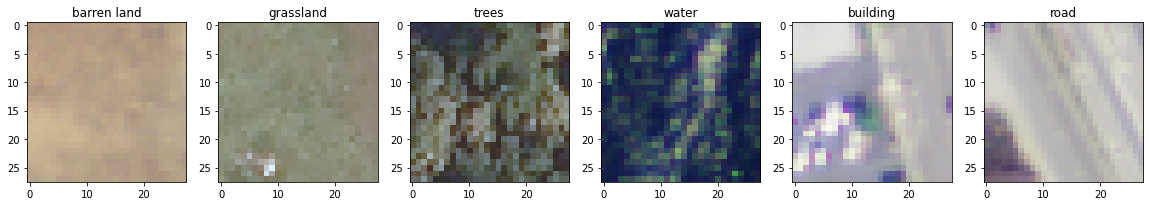

In [ ]:
#Plot some sample figures for exploration
fig,ax =plt.subplots(1,6,figsize=(20,10))
ax[0].imshow(Xtrain[1,:,:,:3], cmap='gray', vmin = 0, vmax = 255)
ax[1].imshow(Xtrain[29,:,:,:3])
ax[2].imshow(Xtrain[53,:,:,:3])
ax[3].imshow(Xtrain[7,:,:,:3])
ax[4].imshow(Xtrain[81,:,:,:3])
ax[5].imshow(Xtrain[258,:,:,:3])
ax[0].set_title(ytrain_cat[1])
ax[1].set_title(ytrain_cat[29])
ax[2].set_title(ytrain_cat[53])
ax[3].set_title(ytrain_cat[287])
ax[4].set_title(ytrain_cat[81])
ax[5].set_title(ytrain_cat[258]);

# Building a CNN Using Transfer Learning (VGG-16)

In [ ]:
#Set image height, image width and batchsize
batch_size = 64
img_height = 28
img_width = 28

In [ ]:
#Using ImageDataGenerator to split training data to train and validation set
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set validation split

val_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) 

train_generator = train_datagen.flow(
    Xtrain[:,:,:,:3], ytrain, 
    batch_size=batch_size, shuffle = True, 
    subset='training') # set as training data

validation_generator = val_datagen.flow(
    Xtrain[:,:,:,:3], ytrain,  # same directory as training data
    batch_size=batch_size, shuffle = True, 
    subset='validation') # set as validation data

#### Understanding the VGG16 architecture

In [ ]:
# load the model
model_vgg = VGG16()
# summarize the model
model_vgg.summary()

553467904/553467096 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

## Input images to VGG16 after preprocessing by Upsampling Images


###### In this method, you input the image of size 28 by 28 and upsample image to (56 by 56) which is larger the minimum image size for vgg16 (32 by 32). Then load the Vgg16 model weights alone, set all parameters to be non-trainable and updated the last layer of the model to have a softmax of 6.


In [ ]:
model_vgg = vgg16.VGG16(weights='imagenet', include_top=False ,input_shape=(56,56,3), pooling = 'max') #Larger than Minimum size for Vgg16
for layer in model_vgg.layers:
      layer.trainable = False
      print('Layer ' + layer.name + ' frozen.')
model_vgg.summary()

model_base_up = Sequential()
model_base_up.add(layers.UpSampling3D((2,2,1), input_shape = (28,28,3)))
model_base_up.add(model_vgg)

model_base_up.add(layers.Flatten())

model_base_up.add(layers.Dense(128, activation  = 'relu'))
model_base_up.add(layers.Dropout(0.5))
model_base_up.add(layers.Dense(6, activation='softmax'))


model_base_up.summary()



58892288/58889256 [==============================] - 0s 0us/step
Layer input_2 frozen.
Layer block1_conv1 frozen.
Layer block1_conv2 frozen.
Layer block1_pool frozen.
Layer block2_conv1 frozen.
Layer block2_conv2 frozen.
Layer block2_pool frozen.
Layer block3_conv1 frozen.
Layer block3_conv2 frozen.
Layer block3_conv3 frozen.
Layer block3_pool frozen.
Layer block4_conv1 frozen.
Layer block4_conv2 frozen.
Layer block4_conv3 frozen.
Layer block4_pool frozen.
Layer block5_conv1 frozen.
Layer block5_conv2 frozen.
Layer block5_conv3 frozen.
Layer block5_pool frozen.
Layer global_max_pooling2d frozen.
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 56, 56, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 56, 56, 64)        1792      
____________________________________________________

## Define a function to calculate f1 metric, precicion and recall

Keras 2.0 metrics f1, precision, and recall have been removed. The solution is to use a custom metric function. ([Ref](https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras))

In [ ]:
#Define a custom function to calculate precicion, recall, f-1 score 
def f_precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f_recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f_f1score ( y_true, y_pred):
    precision = f_precision(y_true, y_pred)
    recall = f_recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))




def f_balanced_accuracy(y_true, y_pred):
      
      ## Sensitivity
      true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
      possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
      sensitivity = true_positives / (possible_positives + K.epsilon())
      
      ### Specificity
      true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
      possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
      specificity =  true_negatives / (possible_negatives + K.epsilon())
      balanced_accuracy = (sensitivity + specificity) / 2
      return balanced_accuracy







#### Ref: https://www.deepideas.net/unbalanced-classes-machine-learning/


# # def auroc(y_true, y_pred):
# #   return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)
# auc_metrics = tf.keras.metrics.AUC(num_thresholds=200, curve='ROC', summation_method='interpolation', name=None,
#      dtype=None, thresholds=None, multi_label=False, label_weights=None)


In [ ]:
# model_vgg = vgg16.VGG16(weights='imagenet', include_top=False ,input_shape=(32,32,3)) #Minimum size for Vgg16
# #model_vgg.summary(line_length=150)

# model_2 = models.Sequential()
# #model.add(ZeroPadding2D((1, 1)))
# model_2.add(ZeroPadding2D(((1, 1), (1, 1))))
# model_2.add(Conv2D(3, (3, 3), padding='same', input_shape=(28,28,3))) #Adding padding to image
# model_2.add(model_vgg)
# model_2.add(layers.Flatten())

# model_2.add(layers.Dense(512, activation  = 'relu'))
# model_2.add(layers.Dropout(0.2))
# model_2.add(layers.Dense(6, activation='softmax'))


# # input_2 = model.input
# # output_2 = new_layer2(flatten(model.output))

# # model2 = Model(input_2, output_2)
# # model2.summary(line_length=150)

In [ ]:
#Adding model check point
checkpointer = ModelCheckpoint(filepath="vgg_weights_upsampling.hdf5", 
                               monitor = 'val_f_balanced_accuracy',
                               verbose=1, 
                               mode = 'max',
                               save_best_only=True)

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model_base_up.compile(optimizer = opt,
             loss = 'categorical_crossentropy',
            metrics = ['accuracy', f_f1score, f_precision, f_recall, f_balanced_accuracy])

In [ ]:
history = model_base_up.fit_generator(
    train_generator,
    steps_per_epoch=150,
    epochs = 20, 
    validation_data=validation_generator, verbose = 1, callbacks = [checkpointer], validation_steps = 50, workers = 4, use_multiprocessing = True) 

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
149/150 [============================>.] - ETA: 0s - loss: 0.7461 - accuracy: 0.7065 - f_f1score: 0.6710 - f_precision: 0.8025 - f_recall: 0.5909 - f_balanced_accuracy: 0.7823WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.

Epoch 00001: val_f_balanced_accuracy improved from -inf to 0.85647, saving model to vgg_weights_upsampling.hdf5
150/150 [==============================] - 7s 48ms/step - loss: 0.7445 - accuracy: 0.7073 - f_f1score: 0.6721 - f_precision: 0.8035 - f_recall: 0.5919 - f_balanced_accuracy: 0.7829 - val_loss: 0.4676 - val_accuracy: 0.7941 - val_f_f1score: 0.7884 - val_f_precision: 0.8439 - val_f_recall: 0.7403 - val_f_balanced_accuracy: 0.8565
Epoch 2/20
149/150 [============================>.] - ETA: 0s - loss: 0.4593 - accuracy: 0.8082 - f_f1score: 0.8005 - f_precisio

## Evaluate Model Performance 

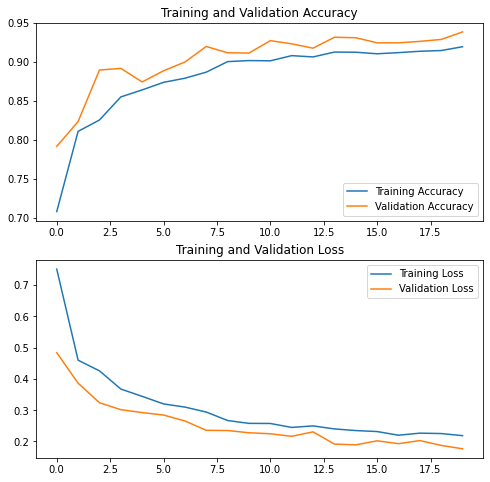

In [ ]:
## Evaluate Model Performance
epochs = len(history.history['accuracy'])
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


## Saving and loading model weights

In [ ]:
# serialize model to JSON
json_file = model_base_up.to_json()
with open("vgg-base-upsampling.json", "w") as f:
    f.write(json_file)

# serialize weights to HDF5
model_base_up.save_weights("vgg-base-upsampling.h5")
print("Saved model to disk")
 
# later...
 
model_base_up.save("tl-2.tf")


Saved model to disk
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: tl-2.tf/assets


In [ ]:
 # load json and create model
json_file = open('vgg-base-upsampling.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("vgg-base-upsampling.h5")
print("Loaded model from disk")
 
# # evaluate loaded model on test data
# loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
# score = loaded_model.evaluate(X, Y, verbose=0)
# print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk


# Evaluate Test Data

In [ ]:
# Evaluate model performance on test dataset
Xtest_rescaled = Xtest[:,:,:,:3]/255

predictions = model_base_up.predict(Xtest_rescaled)


In [ ]:
#Map predictions to actual categories
preds_cat = pd.DataFrame(predictions).idxmax(axis=1).map(land_categories)


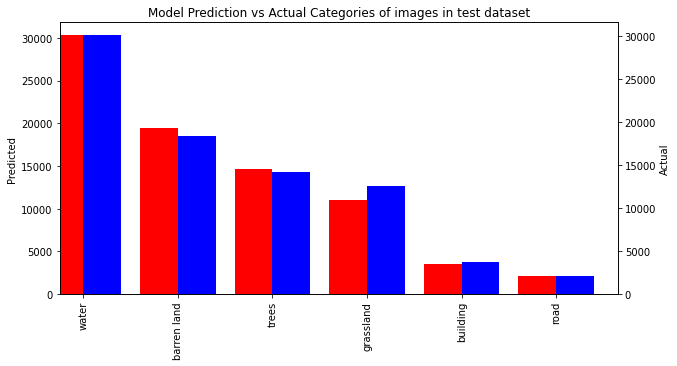

In [ ]:
# Plot predicted vs actual results 
pred_counts =preds_cat.value_counts()
act_counts = ytest_cat.value_counts()


fig=plt.figure(figsize=(10,5))

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.4

pred_counts.plot(kind='bar', color='red', ax=ax, width=width, position=1)
act_counts.plot(kind='bar', color='blue', ax=ax2, width=width, position=0)

ax.set_ylabel('Predicted')
ax2.set_ylabel('Actual')

ax.set_title('Model Prediction vs Actual Categories of images in test dataset')

plt.show()



#### Classification Report, Accuracy and Confusion Matrix

In [ ]:
#Print classification report
print(classification_report(ytest_cat, preds_cat))

              precision    recall  f1-score   support

 barren land       0.86      0.91      0.89     18367
    building       0.93      0.89      0.91      3714
   grassland       0.87      0.76      0.81     12596
        road       0.88      0.89      0.88      2070
       trees       0.93      0.96      0.94     14185
       water       0.99      1.00      1.00     30068

    accuracy                           0.93     81000
   macro avg       0.91      0.90      0.91     81000
weighted avg       0.93      0.93      0.93     81000



In [ ]:
#Print Balanced accuracy
print('Overall Balanced Accuracy: %2.2f%%' % (100*balanced_accuracy_score(ytest_cat, preds_cat)))

Overall Balanced Accuracy: 90.13%


In [ ]:
#Print overall accuracy
print('Overall Accuracy: %2.2f%%' % (100*accuracy_score(ytest_cat, preds_cat)))

Overall Accuracy: 92.79%


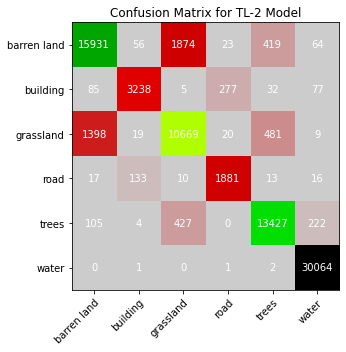

In [ ]:
#Plot confusion matrix
cm = confusion_matrix(ytest_cat, preds_cat)

fig, ax = plt.subplots(figsize = (5,5))
im = ax.imshow(cm, cmap = plt.cm.nipy_spectral_r)

# We want to show all ticks...
ax.set_xticks(np.arange(len(land_categories)))
ax.set_yticks(np.arange(len(land_categories)))
# ... and label them with the respective list entries
ax.set_xticklabels(['barren land','building','grassland','road','trees','water'])
ax.set_yticklabels(['barren land','building','grassland','road','trees','water'])

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(cm)):
    for j in range(len(cm)):
        text = ax.text(j, i, cm[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Confusion Matrix for TL-2 Model")
fig.tight_layout()
plt.show()

#### Determining Prediction Errors

In [ ]:
#Create dataframe to store actual and predicted categories
prediction_err  = pd.DataFrame()
prediction_err = prediction_err.append([ytest_cat, preds_cat]).T
prediction_err.columns = ['Actual','Predicted']
prediction_err.head(5)

Actual    Predicted
0        trees        trees
1        trees        trees
2        water        water
3  barren land  barren land
4        water        water

In [ ]:
#Determine mismatches by comapring both labels
pred_mismatch = prediction_err.loc[(prediction_err.Actual != prediction_err.Predicted)]
print('Overall total mismatches:' , (len(pred_mismatch)))

Overall total mismatches: 6253


In [ ]:
### Reset index in pred_mismatch such that first column is the row number in prediction_error
pred_mismatch.reset_index(inplace=True)
pred_mismatch.head()

index       Actual    Predicted
0     19     building         road
1     27  barren land    grassland
2     34     building  barren land
3     37  barren land    grassland
4     56        trees        water

In [ ]:
e1 = pred_mismatch[(pred_mismatch['Actual'].values == 'barren land')].head(1)['index'].values.item()
e2 = pred_mismatch[(pred_mismatch['Actual'].values == 'building')].head(1)['index'].values.item()
e3 = pred_mismatch[(pred_mismatch['Actual'].values == 'grassland')].head(1)['index'].values.item()
e4 = pred_mismatch[(pred_mismatch['Actual'].values == 'road')].head(1)['index'].values.item()
e5 = pred_mismatch[(pred_mismatch['Actual'].values == 'trees')].head(1)['index'].values.item()
e6 = pred_mismatch[(pred_mismatch['Actual'].values == 'water')].head(1)['index'].values.item()

Count the number of mismatches in each category

In [ ]:
pred_mismatch.groupby(['Actual']).describe().reset_index()

Actual   index                ...                           
                 count          mean  ...      50%      75%      max
0  barren land  3159.0  40503.592909  ...  40274.0  60853.5  80949.0
1     building   301.0  40610.026578  ...  42699.0  60939.0  80814.0
2    grassland  1828.0  40587.326039  ...  40633.5  59830.5  80991.0
3         road   324.0  37048.703704  ...  36895.5  55975.5  80395.0
4        trees   639.0  40273.776213  ...  40728.0  59391.5  80905.0
5        water     2.0  38892.000000  ...  38892.0  40073.0  41254.0

[6 rows x 9 columns]

In [ ]:
#Create a dataframe of total mismatches using group by
mismatch_df = pred_mismatch.groupby(['Actual']).describe().reset_index()


#Drop columns that are not needed
mismatch_df = mismatch_df.drop(mismatch_df.columns[[2,3,4,5,6,7,8]], axis = 1)


##Rename columns
mismatch_df.columns = [('Class'), ('Total Mismatches')]

In [ ]:
mismatch_df.head()

Class  Total Mismatches
0  barren land            3159.0
1     building             301.0
2    grassland            1828.0
3         road             324.0
4        trees             639.0

## Plotting some images where the model predictions were incorrect

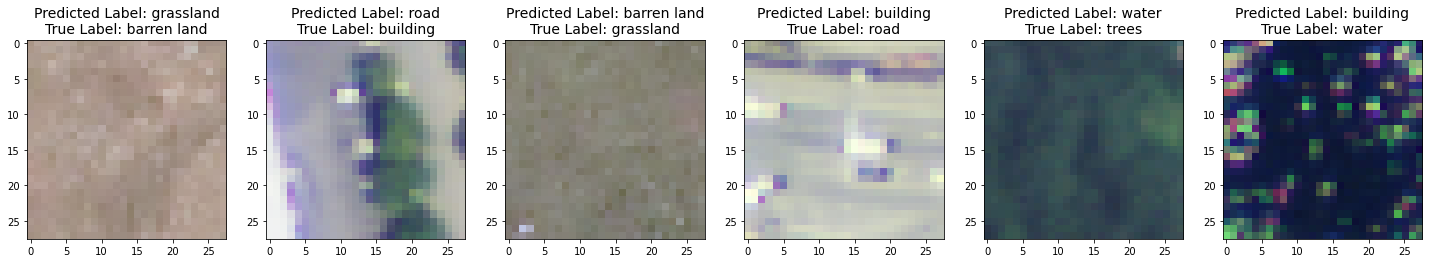

In [ ]:
#Plot some sample figures for exploration
fig,ax =plt.subplots(1,6,figsize=(25,15))
ax[0].imshow(Xtest[e1,:,:,:3], cmap='gray', vmin = 0, vmax = 255)
ax[1].imshow(Xtest[e2,:,:,:3])
ax[2].imshow(Xtest[e3,:,:,:3])
ax[3].imshow(Xtest[e4,:,:,:3])
ax[4].imshow(Xtest[e5,:,:,:3])
ax[5].imshow(Xtest[e6,:,:,:3])
ax[0].set_title("Predicted Label: " + prediction_err.loc[e1, 'Predicted']+ '\n' +"True Label: "+prediction_err.loc[e1, 'Actual'], fontsize = 14)
ax[1].set_title("Predicted Label: " + prediction_err.loc[e2, 'Predicted']+ '\n' +"True Label: "+prediction_err.loc[e2, 'Actual'], fontsize = 14)
ax[2].set_title("Predicted Label: " + prediction_err.loc[e3, 'Predicted']+ '\n' +"True Label: "+prediction_err.loc[e3, 'Actual'], fontsize = 14)
ax[3].set_title("Predicted Label: " + prediction_err.loc[e4, 'Predicted']+ '\n' +"True Label: "+prediction_err.loc[e4, 'Actual'], fontsize = 14)
ax[4].set_title("Predicted Label: " + prediction_err.loc[e5, 'Predicted']+ '\n' +"True Label: "+prediction_err.loc[e5, 'Actual'], fontsize = 14)
ax[5].set_title("Predicted Label: " + prediction_err.loc[e6, 'Predicted']+ '\n' +"True Label: "+prediction_err.loc[e6, 'Actual'], fontsize = 14);


# Making predictions on a new image


## Single label image classification

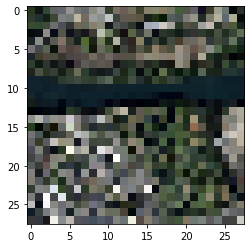

(1, 28, 28, 3)


In [ ]:
#Resize to 28 by 28 image to make predictions on single class image label
img_path = './NAIP-Redding-2-small.png'

img = image.load_img(img_path, target_size = (28,28,3))

img_tensor = image.img_to_array(img)

img_tensor = np.expand_dims(img_tensor, axis = 0)

img_tensor /= 255.

plt.imshow(img_tensor[0])
plt.show()
print(img_tensor.shape)


In [ ]:
# predicting images
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])
#classes = model.predict_classes(images, batch_size=10)
classes  = (loaded_model.predict(images) > 0.5).astype("int32")

#Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
print("Predicted class is:",classes)

Predicted class is: [[0 0 0 1 0 0]]


## Multi label image classification

In [ ]:
#Print the original image
img_path = './NAIP-Redding-2-small.png'
img = image.load_img(img_path, target_size = (5600,5600,3))
img_tensor = image.img_to_array(img)

img_tensor = np.expand_dims(img_tensor, axis = 0)

img_tensor /= 255.

plt.imshow(img_tensor[0])
plt.show()
print(img_tensor.shape)



In [ ]:
## Determine exact image size
im=Image.open(img_path)
im.size # (width,height) tuple

In [ ]:
files = []
out_path = './NAIP-2/'
files = listdir(out_path)

In [ ]:
#### Making predictions on each jpg file
# load all images into memory
def make_predictions(folder, files):
  count = 0
  predicted_classes, file_tags = list(), list()
  # enumerate files in the directory
  import time
  try:
    for filename in files:
      photo = image.load_img((folder + filename), target_size = (28,28)) #load image

      img_tensor = image.img_to_array(photo)  # convert to numpy array

      img_tensor = np.expand_dims(img_tensor, axis = 0)
      #img_tensor /= 255.
      images = np.vstack([img_tensor]) #The loaded_model takes in an array of size (n, 28, 28, channels) where n is the number of images. Here we add this extra dimension with a value of 1
      # get tags
      tag = filename[:-4]

      # Predictions
      predicted_class = (loaded_model.predict(images) > 0.5).astype("int32")

      # store
      #photos_all.append(images)
      predicted_classes.append(predicted_class)
      file_tags.append(tag)
    
      #photos = asarray(photos_all, dtype='uint8')
      predictions = asarray(predicted_classes, dtype='uint8')
      tags = asarray(file_tags)
      count = count +1
  except Exception as e:
    print(tag, count)
    raise e
  return predictions, tags

In [ ]:
photos_array, predictions_array, file_tags = make_predictions(out_path, files)

Exception ignored in: <bound method IteratorResourceDeleter.__del__ of <tensorflow.python.data.ops.iterator_ops.IteratorResourceDeleter object at 0x7f2d59cf04e0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 537, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1279, in delete_iterator
    tld.op_callbacks, handle, deleter)
KeyboardInterrupt: 


KeyboardInterrupt: ignored

In [ ]:
#Convert the 3d predictions_array to 2D array
predictions = []
for preds in predictions_array: 
    for pred in preds: 
        predictions.append(pred) 


In [ ]:
## Mapping predictions to actual categories
NAIP_image_df = pd.DataFrame()
NAIP_image_df['Class'] = pd.DataFrame(predictions).idxmax(axis=1).map(land_categories)

In [ ]:
#assign all file tags to a new columns
NAIP_image_df['File_tags'] = file_tags


In [ ]:
tile_size_x = 28
tile_size_y = 28
 
 #Split the file tags into three columns and drop the "Tile" column
NAIP_image_df[['Tile', 'Col', 'Row']] = NAIP_image_df['File_tags'].str.split('_', expand = True, )
NAIP_image_df.drop(columns= 'Tile', inplace=True)

 #Divide each row and column by the image tile size
NAIP_image_df['Row'] = (NAIP_image_df['Row'].astype(int)/tile_size_x)
NAIP_image_df['Col'] = (NAIP_image_df['Col'].astype(int)/tile_size_y)
 
 ## Map each land class to integers
for index in range(len(NAIP_image_df)):
  if NAIP_image_df.loc[index,'Class'] == 'building':
    NAIP_image_df.loc[index,'ClassType'] = 0
  elif NAIP_image_df.loc[index,'Class'] == 'barren land':
    NAIP_image_df.loc[index,'ClassType'] = 1
  elif NAIP_image_df.loc[index, 'Class'] == 'trees':
    NAIP_image_df.loc[index, 'ClassType'] = 2
  elif NAIP_image_df.loc[index, 'Class'] == 'grasslands':
    NAIP_image_df.loc[index, 'ClassType'] = 3
  elif NAIP_image_df.loc[index, 'Class'] == 'road':
    NAIP_image_df.loc[index, 'ClassType'] = 4
  elif NAIP_image_df.loc[index, 'Class'] == 'water':
    NAIP_image_df.loc[index, 'ClassType'] = 5


In [ ]:
## Create image
NAIP_image =NAIP_image_df.pivot('Row','Col','ClassType').to_numpy()
NAIP_image

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 5., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [5., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 5., 5.],
       [0., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 0., 5., 5.],
       [0., 0., 0., 0., 0., 5., 4., 5., 0., 0., 0., 5., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 5., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 5., 5., 0., 0., 0.],
       [0., 0., 0., 0., 0

Text(0.5, 1.0, 'Original Image')

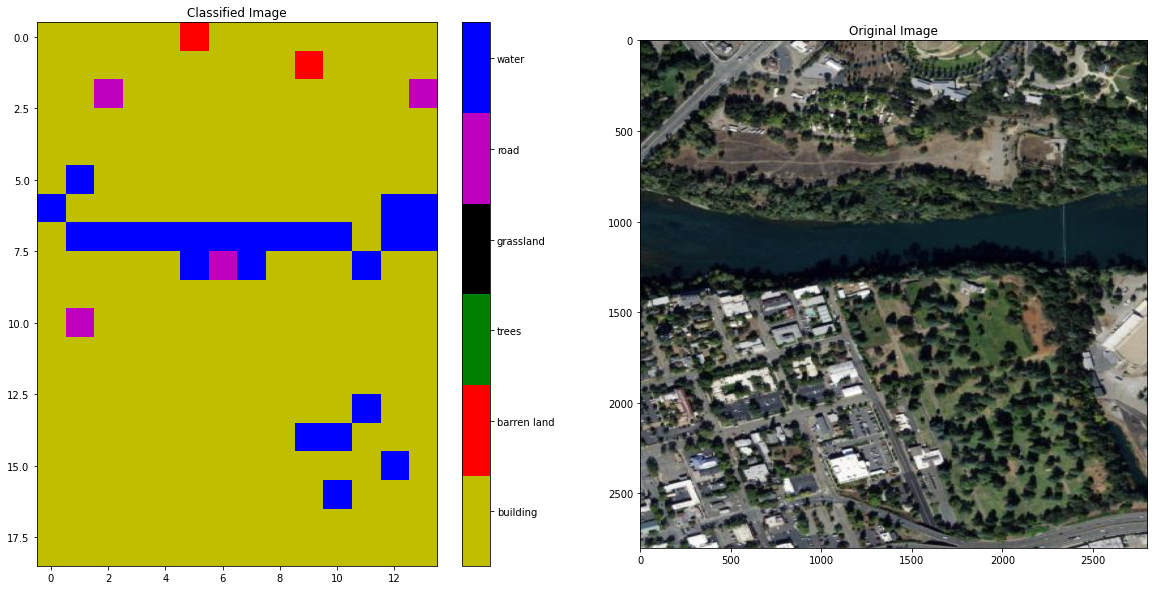

In [ ]:
#Display image classifications

#First creating a color mapping scheme for each land class type
cmap_classes=ListedColormap(['y','r','g','k','m','b'])#custom colormap
#y - building, r - barren land, g - trees, black - grasslands, magenta - road, cyan - water

#Next plot the mapped image and the original image size by side
fig,ax=plt.subplots(1,2,figsize=(20,10))

im=ax[0].imshow(NAIP_image,cmap=cmap_classes)

cbar = fig.colorbar(im, ax=ax[0])
cbar.set_ticks(np.linspace(0.5, 5.5, 7))
cbar.ax.set_yticklabels([land_categories[i] for i in range(6)])
ax[0].set_title('Classified Image')

ax[1].imshow(img_tensor[0])
ax[1].set_title('Original Image')

# Visualizing Filters by maximizing the activation of a specific filter in a target layer


##### Ref - https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/visualizing_what_convnets_learn.ipynb

### Load the feature extraction model



In [ ]:
# The dimensions of our input image
img_width_filter = 180
img_height_filter = 180
# Here we'll visualize the filters from the target layer.
# Set the target layer based on the `model.summary()` layers. Update this to a different layer if you want to change this. 

from tensorflow.keras.models import load_model
#load the model
model = load_model('tl-2.tf', custom_objects={'f_f1score': f_f1score, 'f_precision':f_precision, 'f_recall':f_recall, 'f_balanced_accuracy':f_balanced_accuracy} ).get_layer('vgg16')
model.summary()


layer_name = "block2_conv1"

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 56, 56, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 56, 56, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 56, 56, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 28, 28, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 28, 28, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 28, 28, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 14, 14, 128)       0     

In [ ]:
# Set up a model that returns the activation values for our target layer
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.inputs, outputs=layer.output)


## Setting up gradient ascent process

The loss function to maximize is the mean of the activation of a specific filter in the target layer. Border pixels are excluded.

In [ ]:
def compute_loss(input_image, filter_index):
  activation  = feature_extractor(input_image)

  #Remove border artifacts by involving only non-border pixels in the loss

  filter_activation = activation[:, 2:-2, 2:-2, filter_index]
  return tf.reduce_mean(filter_activation)


In [ ]:
@tf.function
def gradient_ascent_step(img, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, filter_index)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    return loss, img


In [ ]:
def initialize_image():
    # We start from a gray image with some random noise
    img = tf.random.uniform((1, img_width_filter, img_height_filter, 3))
    # ResNet50V2 expects inputs in the range [-1, +1].
    # Here we scale our random inputs to [-0.125, +0.125]
    return (img - 0.5) * 0.25


def visualize_filter(filter_index):
    # We run gradient ascent for 20 steps
    iterations = 30
    learning_rate = 10.0
    img = initialize_image()
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(img, filter_index, learning_rate)

    # Decode the resulting input image
    img = deprocess_image(img[0].numpy())
    return loss, img


def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= np.mean(img)
    img /= np.std(img) + 1e-5
    img *= 0.15

    # Center crop
    img = img[25:-25, 25:-25, :]

    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img


In [ ]:
from IPython.display import Image, display

loss, img = visualize_filter(5)
keras.preprocessing.image.save_img("5.png", img)

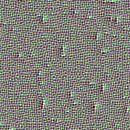

In [ ]:
display(Image("5.png"))

## Visualizing all fitlers in the target layer

In [ ]:
#Compute image inputs that maximize per-filter activations for the 32 filters in the target layer
all_imgs = []
for filter_index in range(128):
  print("Processing filter %d" % (filter_index,))
  loss, img = visualize_filter(filter_index)
  all_imgs.append(img)



#Building a black black picture for the 8*4 filters, with image size 128*128, 5px margin in between
margin = 5
n1  = 16
n2 = 8
cropped_width = img_width_filter - 25 * 2
cropped_height = img_height_filter- 25 * 2
width = n1 * cropped_width + (n1 -1) * margin
height = n2 * cropped_height + (n2 -1)*margin
stitched_filters = np.zeros((width, height, 3))




#Fill picture with saved filters
for i in range(n1):
  for j in range(n2):
    img = all_imgs[i * n2 + j]
    stitched_filters[
                      (cropped_width + margin)*i : (cropped_width + margin)*i + cropped_width,
                      (cropped_height + margin)*j : (cropped_height + margin)*j + cropped_height, :]  = img
keras.preprocessing.image.save_img("stitched_filterimages_block2_conv1.png", stitched_filters)

Processing filter 0
Processing filter 1
Processing filter 2
Processing filter 3
Processing filter 4
Processing filter 5
Processing filter 6
Processing filter 7
Processing filter 8
Processing filter 9
Processing filter 10
Processing filter 11
Processing filter 12
Processing filter 13
Processing filter 14
Processing filter 15
Processing filter 16
Processing filter 17
Processing filter 18
Processing filter 19
Processing filter 20
Processing filter 21
Processing filter 22
Processing filter 23
Processing filter 24
Processing filter 25
Processing filter 26
Processing filter 27
Processing filter 28
Processing filter 29
Processing filter 30
Processing filter 31
Processing filter 32
Processing filter 33
Processing filter 34
Processing filter 35
Processing filter 36
Processing filter 37
Processing filter 38
Processing filter 39
Processing filter 40
Processing filter 41
Processing filter 42
Processing filter 43
Processing filter 44
Processing filter 45
Processing filter 46
Processing filter 47
Pr

Conv2d_1: All the filters


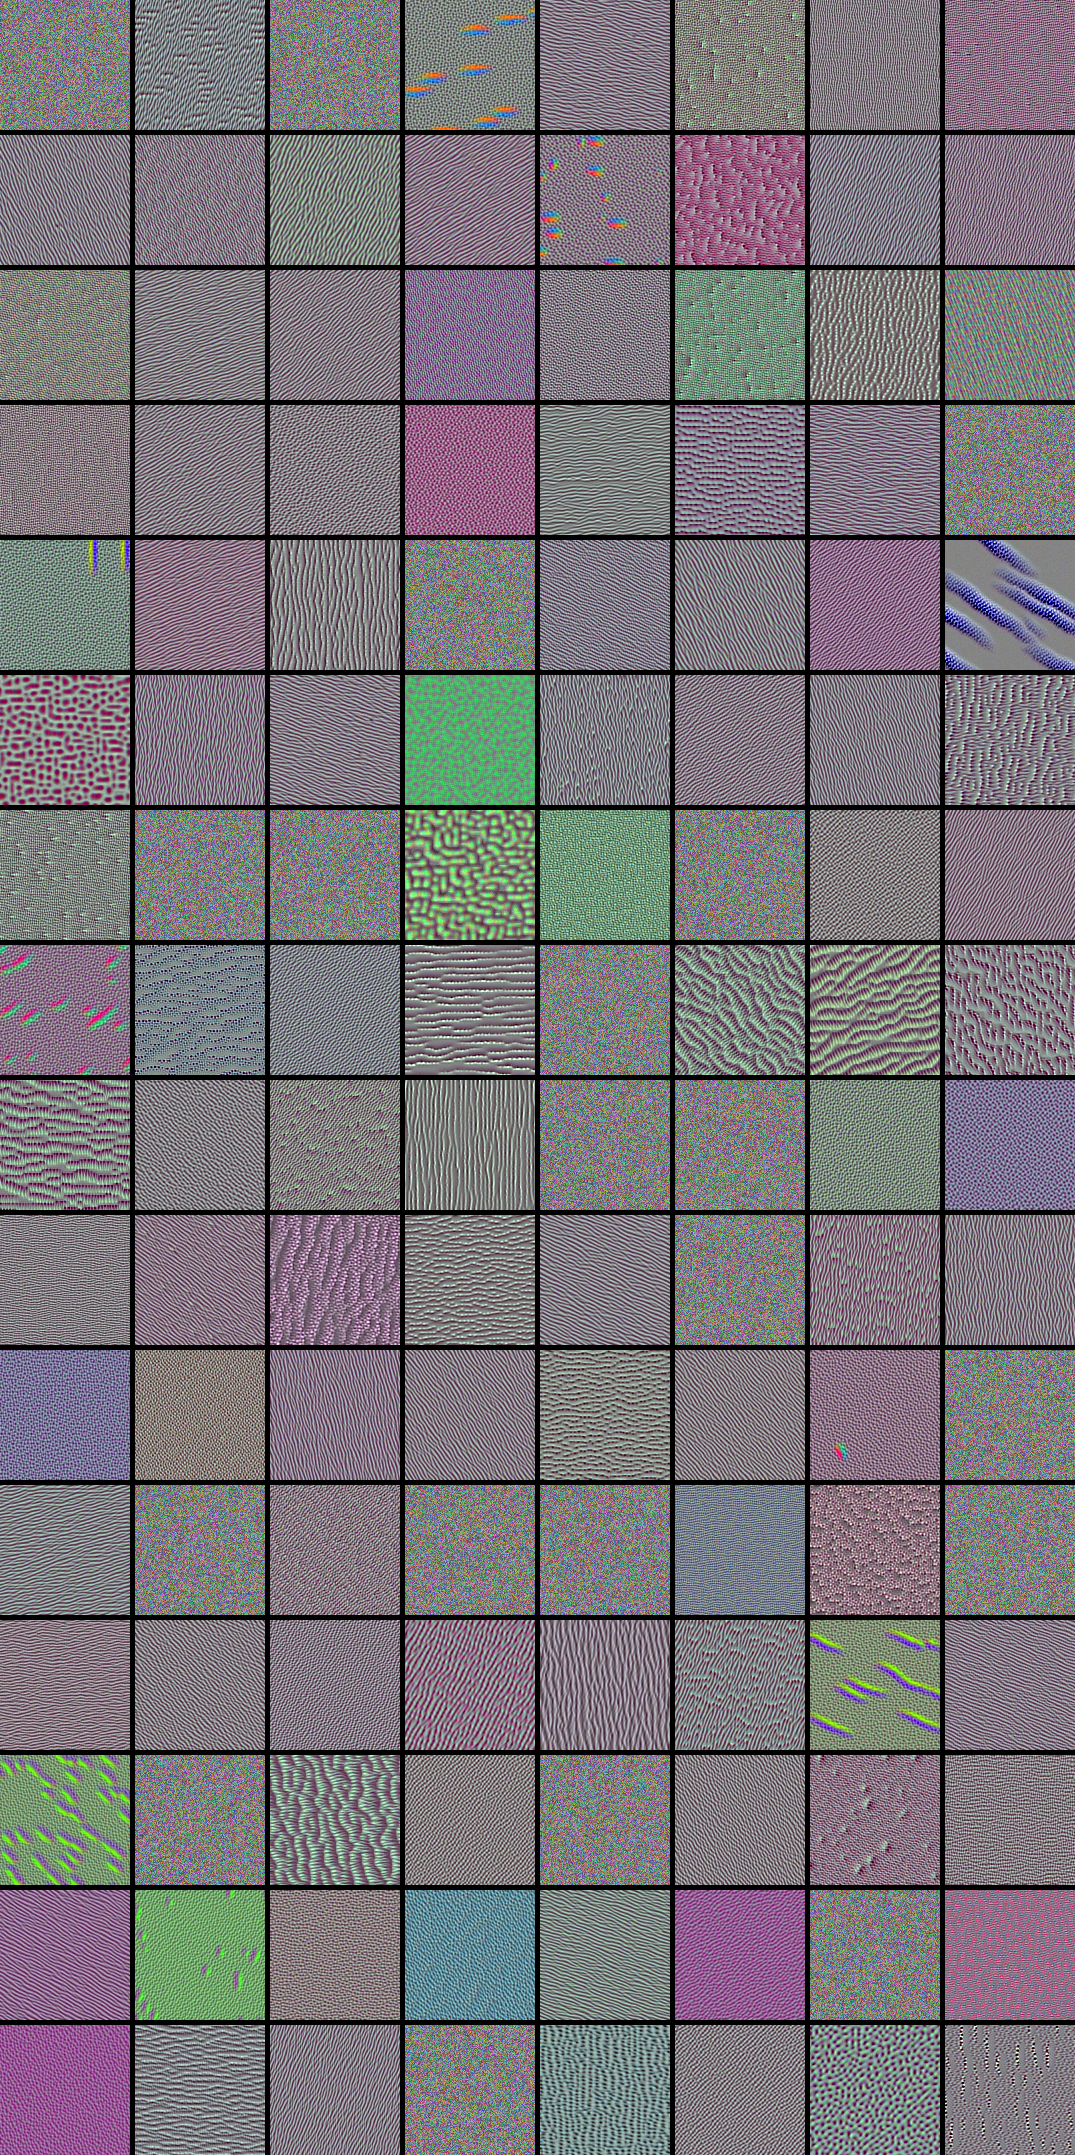

In [ ]:
print("Conv2d_1: All the filters")
display(Image("stitched_filterimages_block2_conv1.png"))

In [ ]:
print("Conv2d_1: All the filters")
display(Image("stitched_filterimages_block5_conv2.png"))

Conv2d_1: All the filters
